<b>Goal of the project:</b> find the best model to predict next 7 days of my dog's daily consumption.
<br><b>Dataset:</b> I use the dataset made by myself. I note my dog's each meal in the dataset to track his appetite which might be helpful to identify potential sickness and find reasons behind amount of food consumed in a day (e.g. he has been eating a lot for the last 2 days, so lower appetite the following day should not be surprising).
<br><b>Additional details:</b> My dog is a male shiba, born in September 2024, so it is expected his appetite in the first months of the dataset could be strongly affected by the early-puppyhood weight gain process. This issue is examined the Data Preparation section to determine whether the dataset should be sliced.
<br><br><b>Applied methods:</b>
<ul>
    <li>Simple Exponential Smoothing</li>
    <li>Double Exponential Smoothing</li>
    <li>Triple Exponential Smoothing (Holt-Winters)</li>
    <li>(S)ARIMA</li>
    <li>Prophet</li>
</ul>
<b>Important notes:</b>
<ul>
    <li>Taking into account daily granulation and the meaning of the dataset (tracking dog's consumption), seasonality is <b><u>not</b></u> expected to be present. Even though, seasonality-based methods like Holt-Winters and SARIMA will be tried just out of sheer curiosity.</li>
    <li>Parameter tuning is applited only to selected methods depending on their complexity. Thus, Exponential Smoothing methods will rely on base scenarios (additive trend and autocorrelation-based component).</li>
    <li>I am aware day-to-day changes can be just a random fluctuation or caused by and external factor (exogenous variable) like food type or temperature. To keep the project's size acceptable it has been decided not to include exogenous variables this time.</li>
    <li>Forecast horizon (7 days) is arbitrary.</li>
</ul>

# Libraries and setup

In [84]:
# All-purpose libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
#import os

# Exploratory data analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Time series models and related statistical tests
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

import arch
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch

# Cross-valiadtion and parameter tuning
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import ParameterGrid

# Model evaluation
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Setup
warnings.filterwarnings('ignore')
np.set_printoptions(legacy='1.25')

# Useful functions

In [87]:
# Function to assess model and visualize output
def model_assessment(train, test, predictions, chart_title):
  plt.figure(figsize = (10, 4))

  plt.plot(train, label = 'Train')
  plt.plot(test, label = 'Test')
  plt.plot(predictions, label = "Forecast")

  plt.title(f"Train, Test and Predictions with {chart_title}")
  plt.legend()
  plt.show()

  # Calculating the MAE, RMSE, and MAPE
  mae = mean_absolute_error(test, predictions)
  rmse = root_mean_squared_error(test, predictions)
  mape = mean_absolute_percentage_error(test, predictions)

  # Print the calculated error metrics
  print(f"The MAE is {mae:.2f}")
  print(f"The RMSE is {rmse:.2f}")
  print(f"The MAPE is {100 * mape:.2f} %")

In [88]:
# Function to plot the future
def plot_future(y, forecast, title):

  plt.figure(figsize = (10,4))
    
  plt.plot(y, label = 'Train')
  plt.plot(forecast, label = "Forecast")

  plt.title(f"Train and Forecast with {title}")
  plt.legend()
  plt.show()

# Data preparation

## Loading dataset

In [2]:
#os.chdir("nauka\pies")
#os.getcwd()

In [73]:
raw_df = pd.read_excel("dog_food_consumption.xlsx", sheet_name="Arkusz2", index_col=0, parse_dates=True, usecols=list(range(4,11)))
raw_df.index.name="date"
raw_df.rename(columns={'porcja [g]': 'consumption [g]'}, inplace=True)
raw_df = raw_df.loc[:, ['consumption [g]']]
raw_df = raw_df.groupby(by='date').sum()
raw_df.index.freq='D'

In [74]:
weight_df = pd.read_excel("dog_food_consumption.xlsx", sheet_name="Arkusz2", index_col=0, parse_dates=True, usecols=[0, 1])
weight_df.dropna(inplace=True)
weight_df.rename(columns={'waga psa [kg]': 'dog weight [kg]'}, inplace=True)
weight_df['diff [kg]'] = weight_df.diff()
weight_df['diff [%]'] = weight_df['dog weight [kg]'].pct_change() * 100

## EDA and dataset slicing

Taking into account I am the author of the dataset, I do not need to use basic Pandas' EDA methods like .info(), .describe(). If it was an external dataset, I would use them.

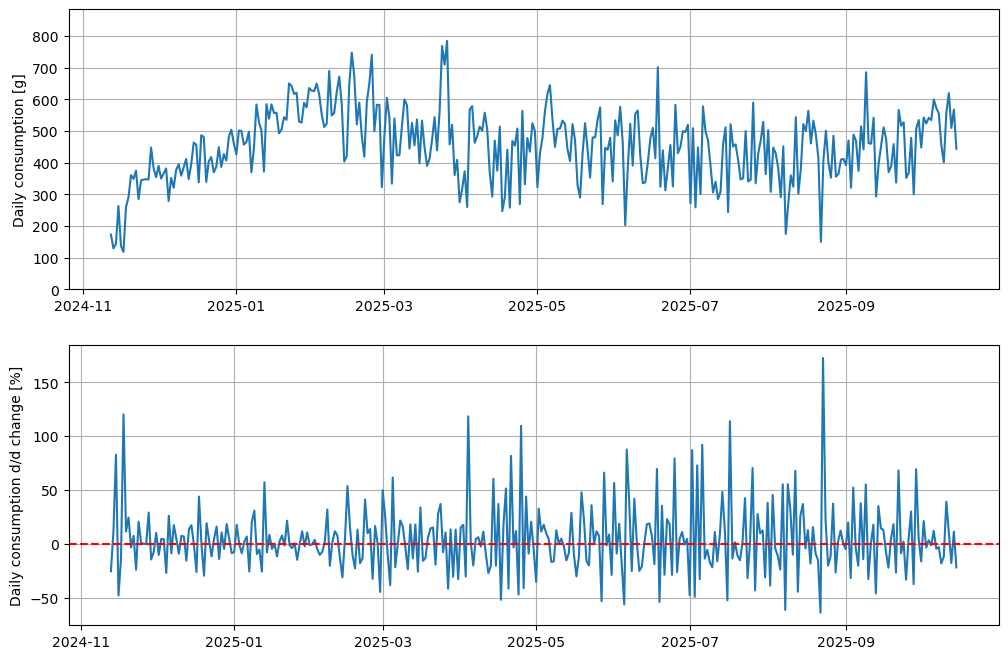

In [77]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(raw_df)
plt.ylabel('Daily consumption [g]')
plt.ylim(bottom=0, top=max(raw_df['consumption [g]'])+100)
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(raw_df.pct_change()*100)
plt.ylabel('Daily consumption d/d change [%]')
plt.axhline(y=0, color='r', ls='--')
#plt.hlines(y=0, color='r', ls='--', xmin=min(raw_df.index), xmax=max(raw_df.index))
plt.grid()

plt.show()

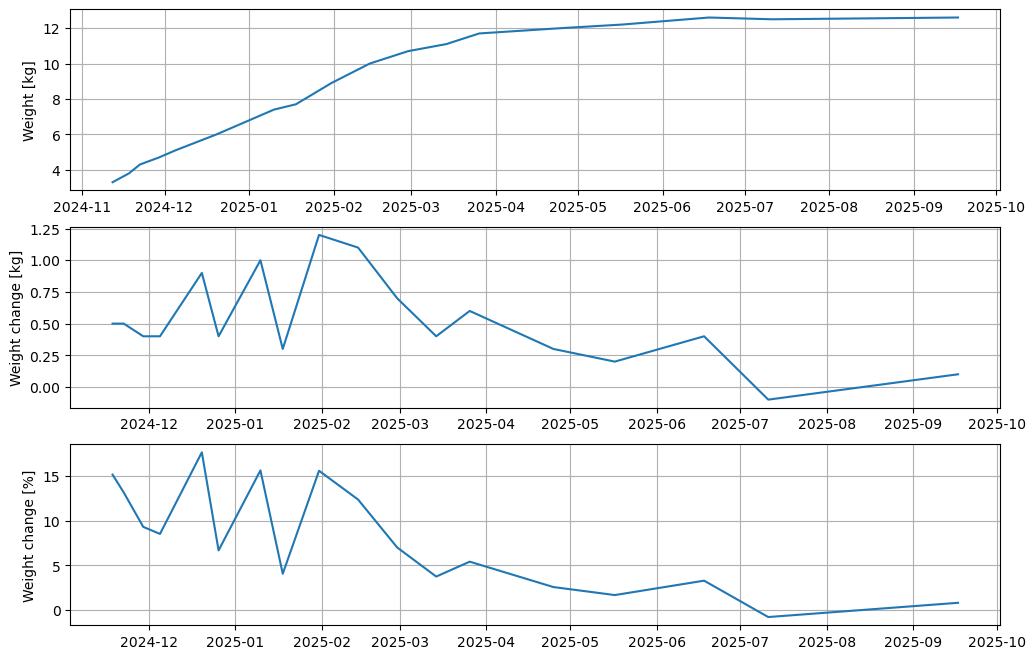

In [78]:
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(weight_df['dog weight [kg]'])
plt.ylabel('Weight [kg]')
#plt.ylim(bottom=0, top=max(weight_df)+100)
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(weight_df['diff [kg]'])
plt.ylabel('Weight change [kg]')
#plt.hlines(y=0, color='r', ls='--', xmin=min(raw_df.index), xmax=max(raw_df.index))
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(weight_df['diff [%]'])
plt.ylabel('Weight change [%]')
plt.grid()

plt.show()

Average male shiba reaches ~10-12 kg, so date of reaching a weight in this area can be treated as the end of the dog's early puppyhood and beginning of the dataset. Around March both appetite and weight gain pace decreased. Thus, the March 1st is treated as the first day of the dataset

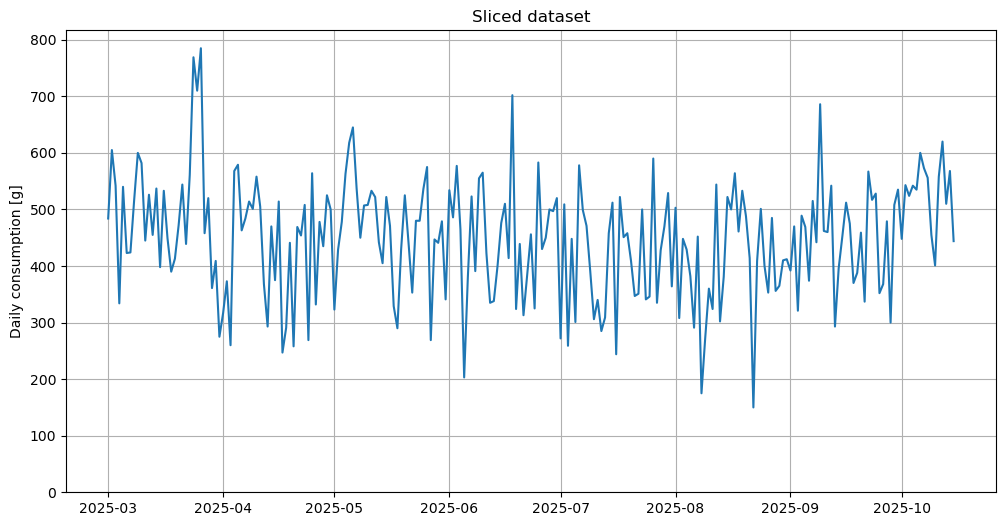

In [79]:
df = raw_df.loc['2025-03-01':].copy()
plt.figure(figsize=(12, 6))
plt.plot(df)
plt.ylabel('Daily consumption [g]')
plt.ylim(bottom=0)
plt.grid()
plt.title('Sliced dataset')
plt.show()

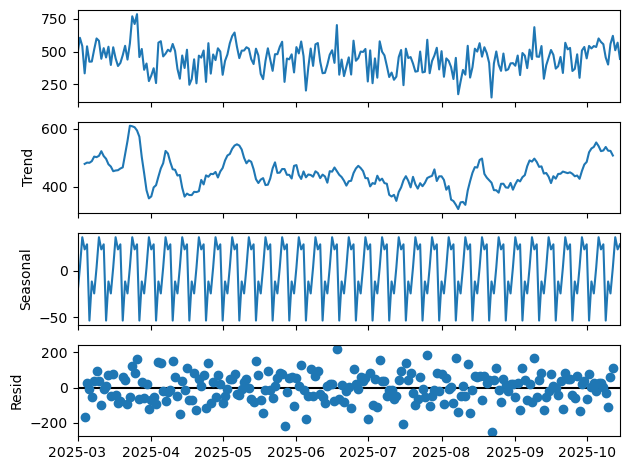

In [80]:
seasonal_decompose(df, model='additive').plot();

Data does not show any multiplicative behavior. Taking this into account, data trends are assumed to be additive.

## Train-test split

In [104]:
periods = 7
train = df.iloc[:-periods]
test = df.iloc[-periods:]

## Autocorrelations

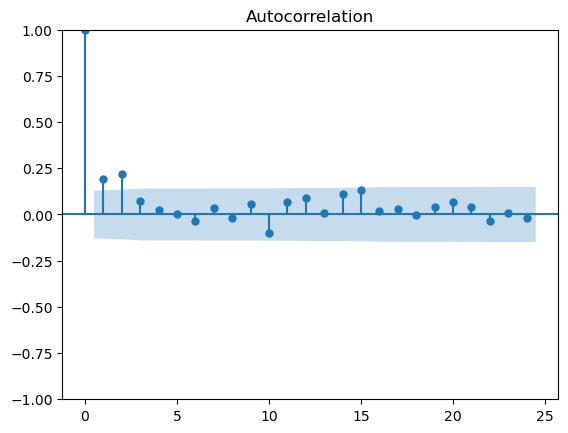

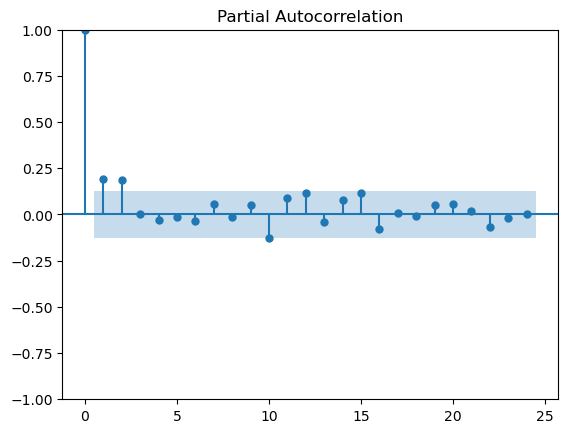

In [81]:
plot_acf(df)
plot_pacf(df);

ACF (q) and PACF (p) values for lags 1 and 2 are barely significant. Daily consumption does not seem to be strongly related to past values.

# Simple Exponential Smoothing

In [95]:
ses_model = SimpleExpSmoothing(train).fit()
ses_model.summary()

Dep. Variable:,consumption [g],No. Observations:,222
Model:,SimpleExpSmoothing,SSE,2345753.753
Optimized:,True,AIC,2060.928
Trend:,None,BIC,2067.733
Seasonal:,None,AICC,2061.112
Seasonal Periods:,None,Date:,"Thu, 16 Oct 2025"
Box-Cox:,False,Time:,18:57:00
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0563654,alpha,True
initial_level,484.00000,l.0,False


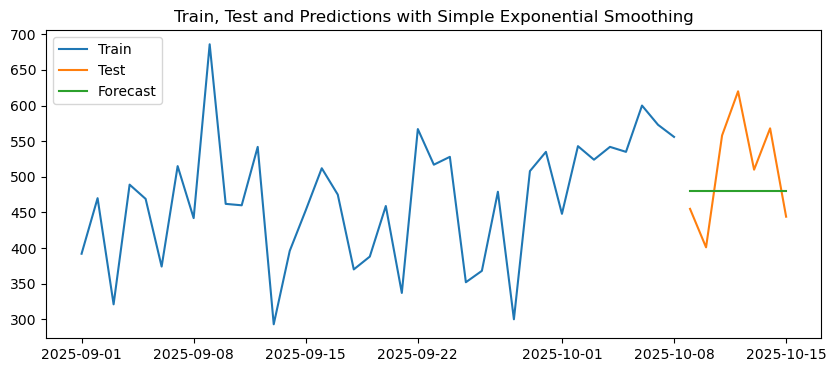

The MAE is 68.06
The RMSE is 78.07
The MAPE is 13.04 %


In [105]:
ses_pred = ses_model.forecast(periods)
model_assessment(train.loc['2025-09':], test, ses_pred, 'Simple Exponential Smoothing')

# Double Exponential Smoothing

In [107]:
model_double = ExponentialSmoothing(train, trend='additive', seasonal=None).fit()
model_double.summary()

Dep. Variable:,consumption [g],No. Observations:,222
Model:,ExponentialSmoothing,SSE,2403579.938
Optimized:,True,AIC,2070.334
Trend:,Additive,BIC,2083.945
Seasonal:,None,AICC,2070.725
Seasonal Periods:,None,Date:,"Thu, 16 Oct 2025"
Box-Cox:,False,Time:,19:08:01
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1228116,alpha,True
smoothing_trend,0.0245766,beta,True


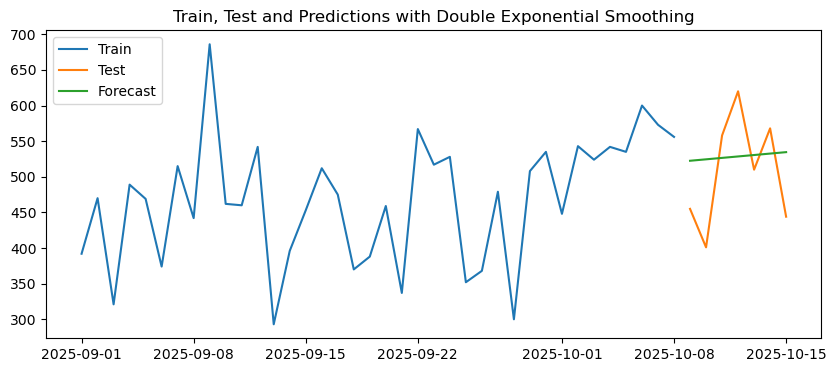

The MAE is 65.79
The RMSE is 74.69
The MAPE is 13.81 %


In [108]:
double_pred = model_double.forecast(periods)
model_assessment(train.loc['2025-09':], test, double_pred, 'Double Exponential Smoothing')

# Triple Exponential Smoothing (Holt-Winters)

Seasonal periods has been assumed using autocorrelation plots.

In [109]:
model_holt = ExponentialSmoothing(train, trend='additive', seasonal='additive', seasonal_periods=2).fit()
model_holt.summary()

Dep. Variable:,consumption [g],No. Observations:,222
Model:,ExponentialSmoothing,SSE,2410376.661
Optimized:,True,AIC,2074.961
Trend:,Additive,BIC,2095.377
Seasonal:,Additive,AICC,2075.637
Seasonal Periods:,2,Date:,"Thu, 16 Oct 2025"
Box-Cox:,False,Time:,19:08:05
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1082984,alpha,True
smoothing_trend,0.0234649,beta,True


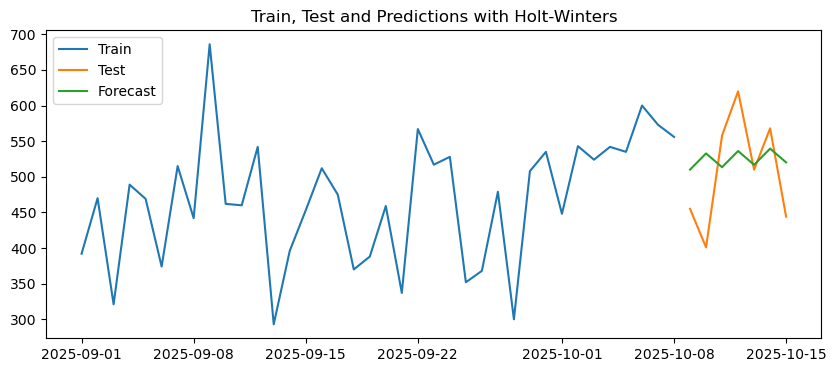

The MAE is 60.96
The RMSE is 71.79
The MAPE is 12.86 %


In [110]:
holt_pred = model_holt.forecast(periods)
model_assessment(train.loc['2025-09':], test, holt_pred, 'Holt-Winters')

# ARIMA

## Testing stationarity

To make a reliable ARIMA model it is needed to check stationarity which is done by the Augmented Dickey-Fuller test.

In [6]:
adf_res = adfuller(df)
print(f'ADF statistic: {adf_res[0]}')
print(f'p-value: {adf_res[1]}')
if adf_res[1] < 0.05:
    print('The series is stationary.')
    print('The series is ready to be inputed into a model.')
else:
    print('The series is NOT stationary.')
    print('The series needs to modified e.g. set different range of differentate the series') 

ADF statistic: -7.766295119724552
p-value: 9.16910829827887e-12
The series is stationary.
The series is ready to be inputed into a model.


## Estimating parameters

### ACF and PACF plots

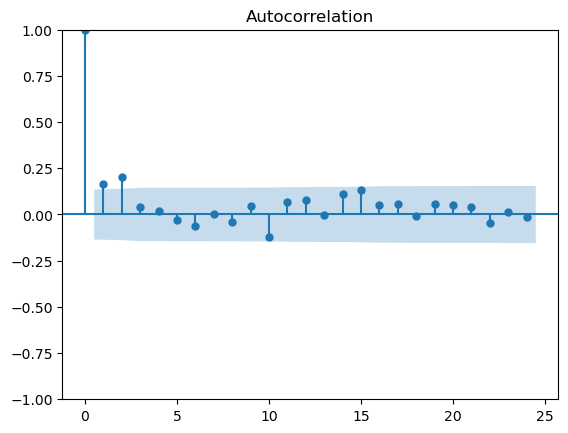

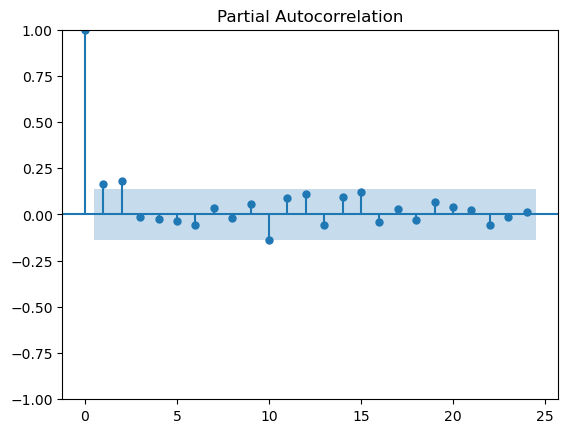

In [7]:
plot_acf(df)
plot_pacf(df);

### Testing multiple parameters combinations

In [8]:
model = auto_arima(df, start_p=0, start_q=0, d=0, max_p=8, max_q=8, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2538.859, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2535.211, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2536.760, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3153.799, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2530.304, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=2532.269, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2532.291, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2535.725, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=2534.271, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2583.414, Time=0.05 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.713 seconds


In [9]:
pq = []
aic = []
bic = []
for p in range(0, 8):
    for q in range(0, 8):
        model = ARIMA(df, order=(p, 0, q))
        res = model.fit()
        pq.append( (p, q) )
        aic.append(res.aic)
        bic.append(res.bic)
    print(f'Models for the p={p} have been done.')
results = pd.DataFrame(data={'p q': pq, 'aic': aic, 'bic': bic})
results.set_index('p q', inplace=True)
print(f'The lowest AIC value is for the {results['aic'].idxmin()}', 
      f'The lowest BIC value is for the {results['bic'].idxmin()}', 
      sep='\n')

Models for the p=0 have been done.
Models for the p=1 have been done.
Models for the p=2 have been done.
Models for the p=3 have been done.
Models for the p=4 have been done.
Models for the p=5 have been done.
Models for the p=6 have been done.
Models for the p=7 have been done.
The lowest AIC value is for the (2, 0)
The lowest BIC value is for the (2, 0)


<Axes: xlabel='p q'>

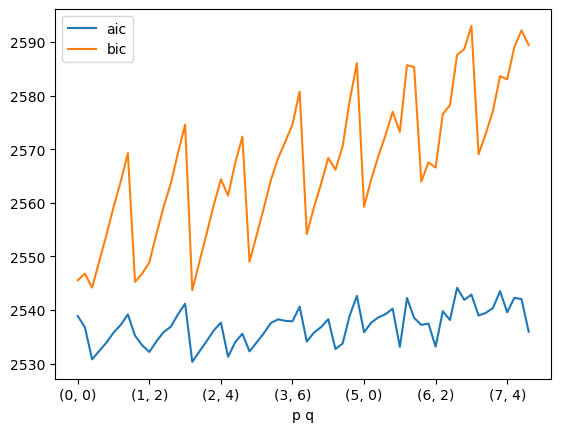

In [10]:
results.plot()

So the parameters will be (2, 0, 5)

## Creating the final ARIMA model

In [11]:
model = ARIMA(df, order=(2, 0, 5))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             weight [g]   No. Observations:                  209
Model:                 ARIMA(2, 0, 5)   Log Likelihood               -1256.633
Date:                Sat, 27 Sep 2025   AIC                           2531.267
Time:                        11:54:39   BIC                           2561.348
Sample:                    03-01-2025   HQIC                          2543.428
                         - 09-25-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        443.3745     11.104     39.928      0.000     421.610     465.139
ar.L1         -1.7001      0.046    -37.168      0.000      -1.790      -1.610
ar.L2         -0.9464      0.045    -20.975      0.000      -1.035      -0.858
ma.L1          1.8999      0.086     21.988      0.000       1.731       2.069
ma.L2          1.4645      0.162      9.031      0.000       1.147       1.782
ma.L3          0.5409      0.179      3.024      0.002       0.190       0.891
ma.L4          0.3128      0.167      1.871      0.061      -0.015       0.640
ma.L5          0.1145      0.089      1.287      0.198      -0.060       0.289
sigma2      1.042e+04   1147.210      9.082      0.000    8170.402    1.27e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 0.39
Prob(Q):                              0.73   Prob(JB):                         0.82
Heteroskedasticity (H):               0.87   Skew:                            -0.10
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

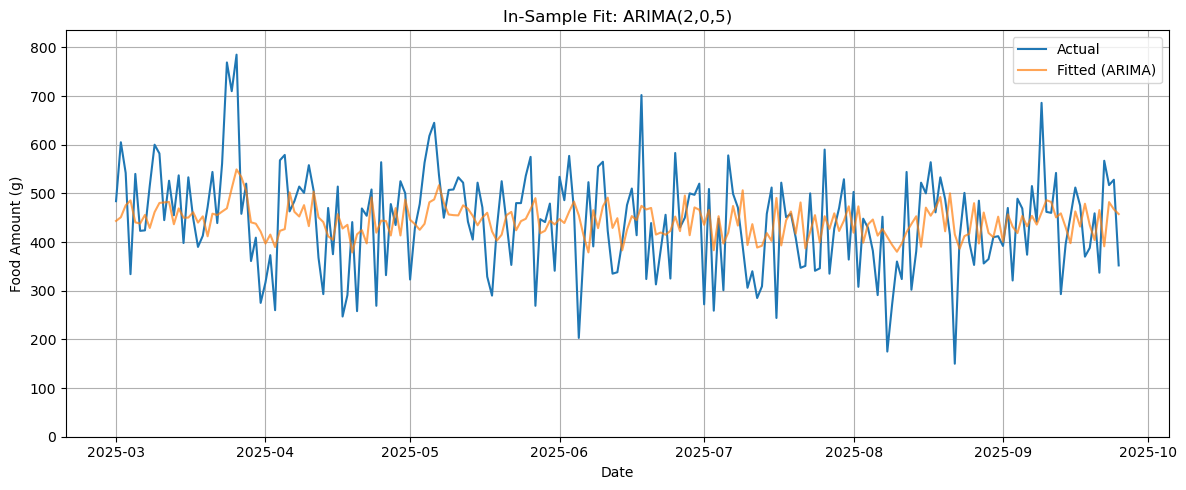

In [12]:
plt.figure(figsize=(12,5))
plt.plot(df, label='Actual')
plt.plot(res.fittedvalues, label='Fitted (ARIMA)', alpha=0.7)
plt.title("In-Sample Fit: ARIMA(2,0,5)")
plt.xlabel("Date")
plt.ylabel("Food Amount (g)")
plt.ylim(bottom=0, top=max(df)+50)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

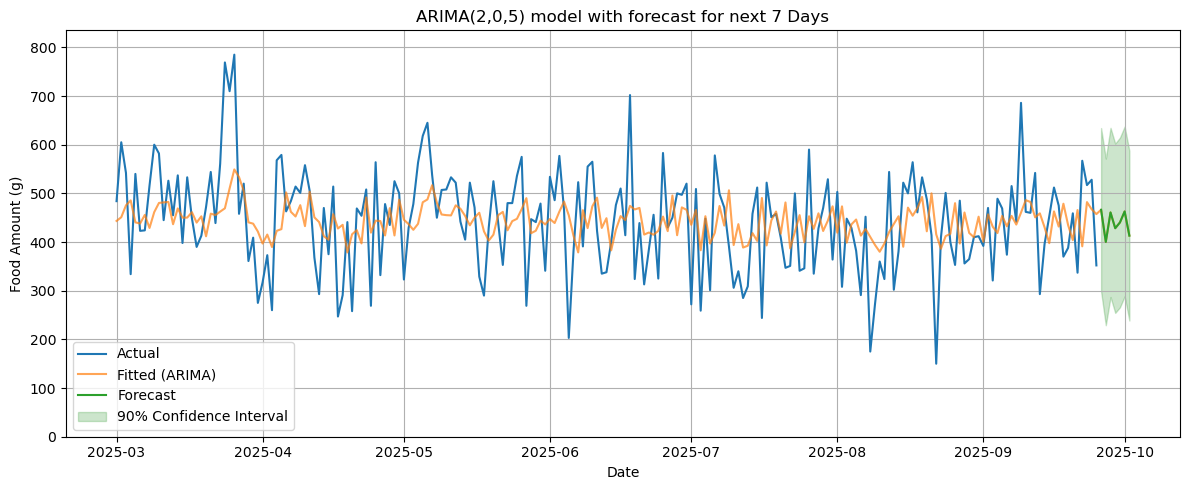

In [13]:
forecast_horizon=7
forecast_res = res.get_forecast(steps=forecast_horizon)
forecast_mean = forecast_res.predicted_mean
conf_int = forecast_res.conf_int(alpha=0.1)
plt.figure(figsize=(12, 5))

plt.plot(df, label="Actual")

plt.plot(pd.concat([res.fittedvalues, forecast_mean]), label='Fitted (ARIMA)', alpha=0.7)

plt.plot(forecast_mean.index, forecast_mean, label="Forecast")

plt.fill_between(forecast_mean.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='green', alpha=0.2, label="90% Confidence Interval")

plt.title(f"ARIMA(2,0,5) model with forecast for next {forecast_horizon} Days")
plt.xlabel("Date")
plt.ylabel("Food Amount (g)")
plt.ylim(bottom=0, top=max(df)+50)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
forecast_mean

2025-09-26    466.293159
2025-09-27    400.303492
2025-09-28    460.844241
2025-09-29    428.395582
2025-09-30    440.231131
2025-10-01    462.895067
2025-10-02    413.161948
Freq: D, Name: predicted_mean, dtype: float64

## Modeling forecast error using neural networks

## Modeling forecast error using GARCH

In [15]:
acorr_ljungbox(res.resid, lags=10)

,lb_stat,lb_pvalue
1,0.104216,0.746827
2,0.156352,0.924802
3,0.159299,0.983876
4,0.161704,0.996902
5,0.357891,0.996411
6,0.417621,0.998701
7,0.944674,0.995672
8,1.460079,0.993351
9,1.510304,0.997070
10,5.545219,0.851917


In [16]:
het_arch(res.resid)

(np.float64(9.164282848789872),
 np.float64(0.5165868484969193),
 0.9075663955272247,
 0.527339967792051)

# Neural networks